# Random Forest

In this notebook, we will try to use Random Forest

### Load and prepare the dataset

In [1]:
from preprocess_data import get_HITL, clean_HITL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

BASE_PATH = "../../data/"
random_state = 42

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


In [4]:
df_network_labels = df_network[["label_n", "label", "attack"]]
df_network = df_network.drop(columns=["label", "label_n", "attack"])
df_network_labels.head()

,label_n,label,attack
0,0,normal,1
1,0,normal,1
2,0,normal,1
3,0,normal,1
4,0,normal,1


In [5]:
from mlsecu.data_exploration_utils import get_column_names, get_nb_of_dimensions, get_nb_of_rows, get_object_column_names, get_number_column_names
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import get_one_hot_encoded_dataframe, remove_nan_through_mean_imputation

Let's just be sure that we are not omitting any important column

In [6]:
assert(len(get_number_column_names(df_network)) + len(get_object_column_names(df_network)) == len(df_network.columns))

In [7]:
df_network[get_number_column_names(df_network)]

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


In [8]:
df_network[get_object_column_names(df_network)]

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]
...,...,...,...,...,...,...,...
243060,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243061,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,Modbus,Read Holding Registers,NaN
243063,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN


##### Remove NaN values for both numerical and categorical columns

In [9]:
df_number_network = remove_nan_through_mean_imputation(df_network[get_number_column_names(df_network)])
df_number_network

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


The two categorical columns with NaN values are `modbus_response` and `modbus_fn`. Let's replace the NaN values with empty strings

In [24]:
df_object_network = get_one_hot_encoded_dataframe(df_network[get_object_column_names(df_network)].fillna(""))
df_object_network = df_object_network.astype(int)
df_object_network

,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,mac_s_4a:35:83:e0:3d:a4,mac_s_74:46:a0:bd:a7:1b,mac_s_e6:3f:ac:c9:a8:8c,mac_s_fa:00:bc:90:d7:fa,mac_s_fe:bb:16:7b:c3:27,mac_d_00:0c:29:47:8c:22,mac_d_00:80:f4:03:fb:12,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243060,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243061,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243062,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243063,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merge the two sub-datasets

In [25]:
df_network_prepared = pd.concat([df_number_network, df_object_network], axis=1)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_network_prepared.reset_index(drop=True, inplace=True)

In [27]:
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def update_labels(df_labels):
    df_labels = df_labels.reset_index(drop=True)

    df_labels["new_labels"] = df_labels["label"].astype('category').cat.codes

    return df_labels

df_network_labels = update_labels(df_network_labels)

### Train RandomForest model

In [29]:
# Prepare train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 1986), (48613, 1986), (194452, 2), (48613, 2))

In [49]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': 300,
    'max_depth': 4,
    'random_state': random_state,
    'n_jobs': -1,
    'criterion': 'log_loss',
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train["label_n"])

RandomForestClassifier(criterion='log_loss', max_depth=4, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [50]:
preds = rf.predict(X_test)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy: ", accuracy_score(y_test["label_n"], preds.round()))
print("Precision: ", precision_score(y_test["label_n"], preds.round()))
print("Recall: ", recall_score(y_test["label_n"], preds.round()))
print("F1: ", f1_score(y_test["label_n"], preds.round()))
print("ROC AUC: ", roc_auc_score(y_test["label_n"], preds))

Accuracy:  0.8672577294139427
Precision:  1.0
Recall:  0.5144104146286402
F1:  0.6793540372670808
ROC AUC:  0.7572052073143201


<Axes: >

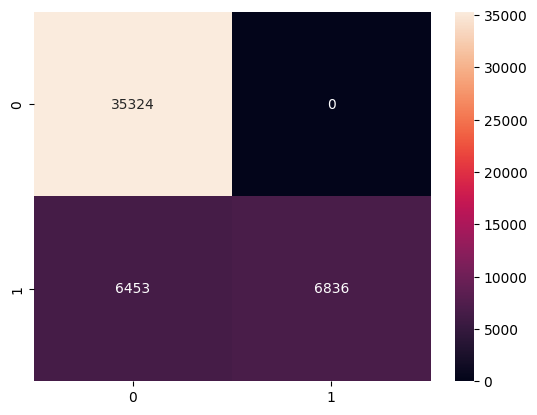

In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test["label_n"], preds.round())
sns.heatmap(confusion_matrix(y_test["label_n"], preds.round()), annot=True, fmt="d")

Performance are pretty good as we achieve 86% of accuracy on the test dataset

Let's see which feature is the most important

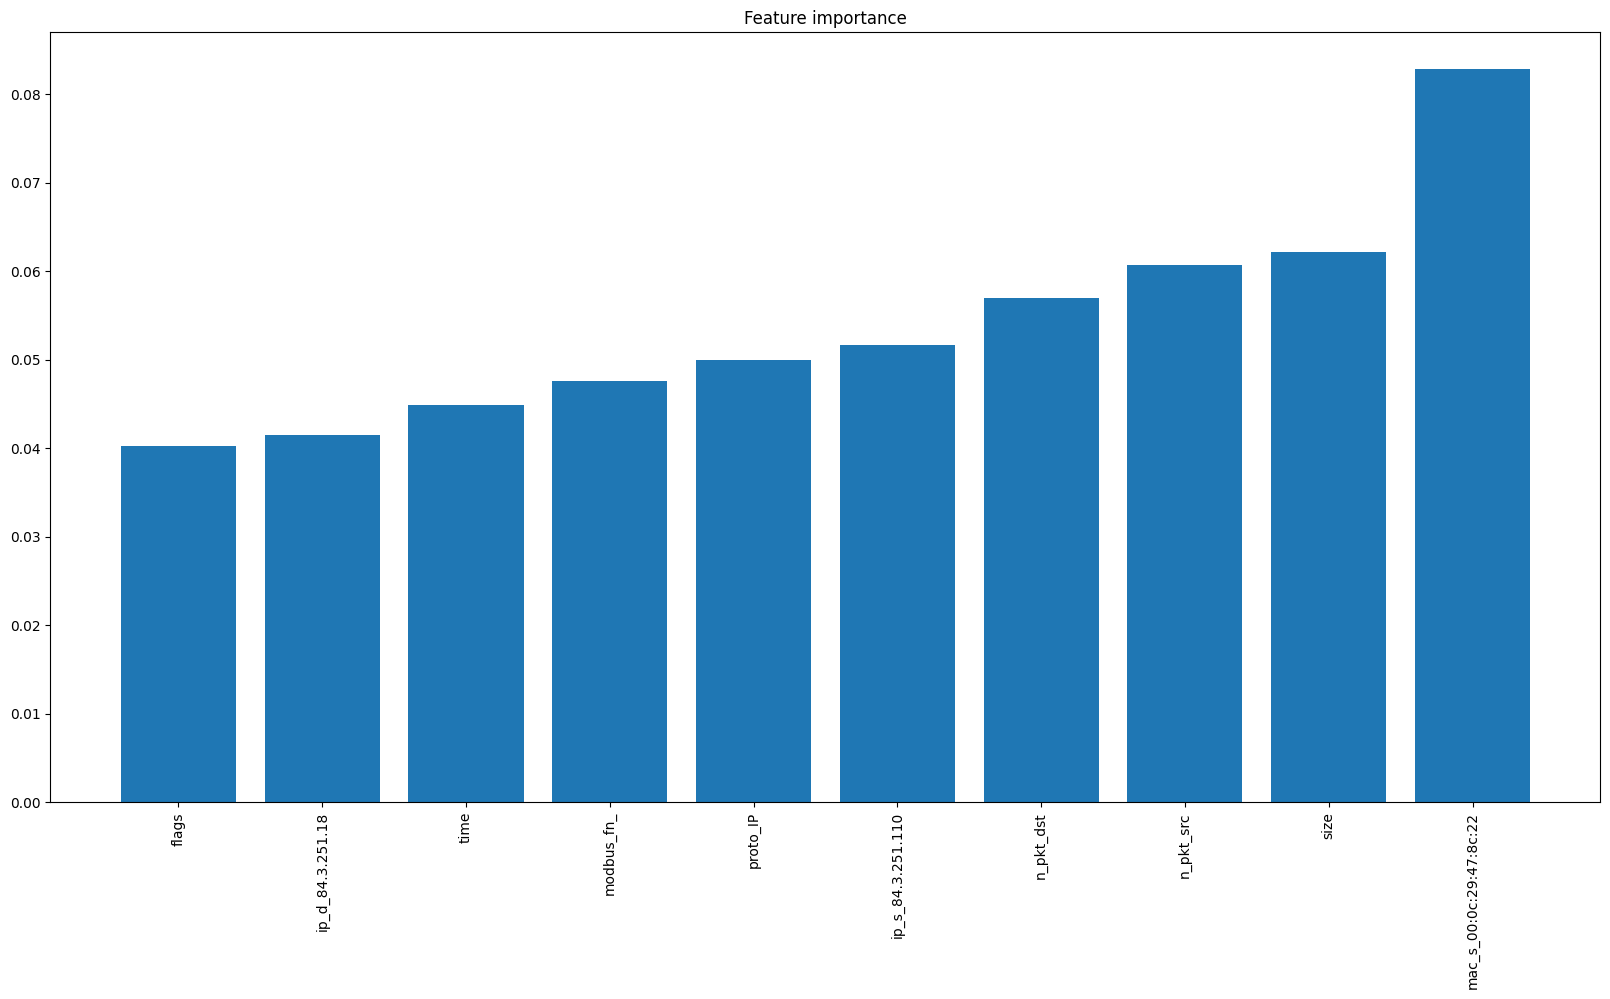

In [53]:
# plot feature importance
importance = rf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()

In [40]:
# let's try to do multi class classification
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train["new_labels"])

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [41]:
preds = rf.predict(X_test)

In [43]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))

Accuracy:  0.8672577294139427
Precision:  0.36910740359527966
Recall:  0.3823906083244397
F1:  0.3740507584132615


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

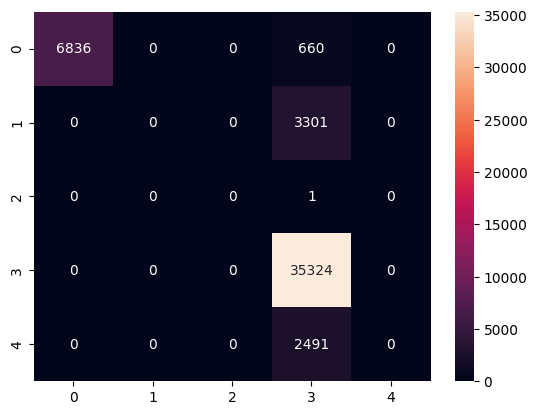

In [44]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")

### Remove features

Let's remove some categorical features and see if the performance are still good

In [56]:
cat_cols = ["proto", "modbus_fn"]
df_object_network = get_one_hot_encoded_dataframe(df_network[cat_cols].fillna(""))
df_object_network = df_object_network.astype(int)
df_object_network

,proto_ARP,proto_ICMP,proto_IP,proto_Modbus,proto_TCP,modbus_fn_,modbus_fn_Read Coils Request,modbus_fn_Read Coils Response,modbus_fn_Read Holding Registers,modbus_fn_Read Holding Registers Response
0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
243060,0,0,0,1,0,0,0,0,1,0
243061,0,0,0,1,0,0,0,0,1,0
243062,0,0,0,1,0,0,0,0,1,0
243063,0,0,0,1,0,0,0,0,1,0


In [74]:
df_network_prepared = pd.concat([df_number_network, df_object_network], axis=1)
df_network_prepared.reset_index(drop=True, inplace=True)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,proto_ARP,proto_ICMP,proto_IP,proto_Modbus,proto_TCP,modbus_fn_,modbus_fn_Read Coils Request,modbus_fn_Read Coils Response,modbus_fn_Read Holding Registers,modbus_fn_Read Holding Registers Response
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,1,0,0,0,1,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1


In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 17), (48613, 17), (194452, 2), (48613, 2))

In [76]:
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'random_state': random_state,
    'n_jobs': -1,
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train["label_n"])

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [77]:
preds = rf.predict(X_test)

In [78]:
print("Accuracy: ", accuracy_score(y_test["label_n"], preds.round()))
print("Precision: ", precision_score(y_test["label_n"], preds.round()))
print("Recall: ", recall_score(y_test["label_n"], preds.round()))
print("F1: ", f1_score(y_test["label_n"], preds.round()))
print("ROC AUC: ", roc_auc_score(y_test["label_n"], preds))

Accuracy:  0.8757328286672289
Precision:  0.9998620689655172
Recall:  0.5454887500940627
F1:  0.7058766249573981
ROC AUC:  0.7727302203646623


<Axes: >

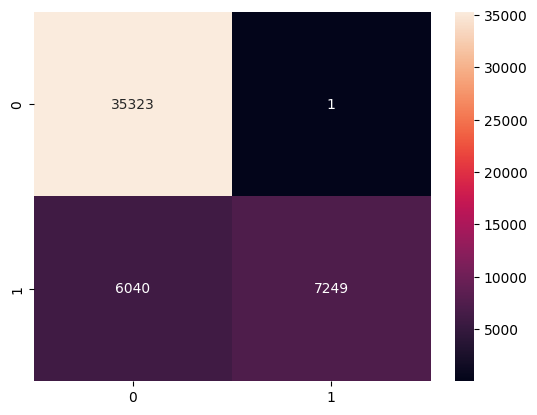

In [79]:
confusion_matrix(y_test["label_n"], preds.round())
sns.heatmap(confusion_matrix(y_test["label_n"], preds.round()), annot=True, fmt="d")

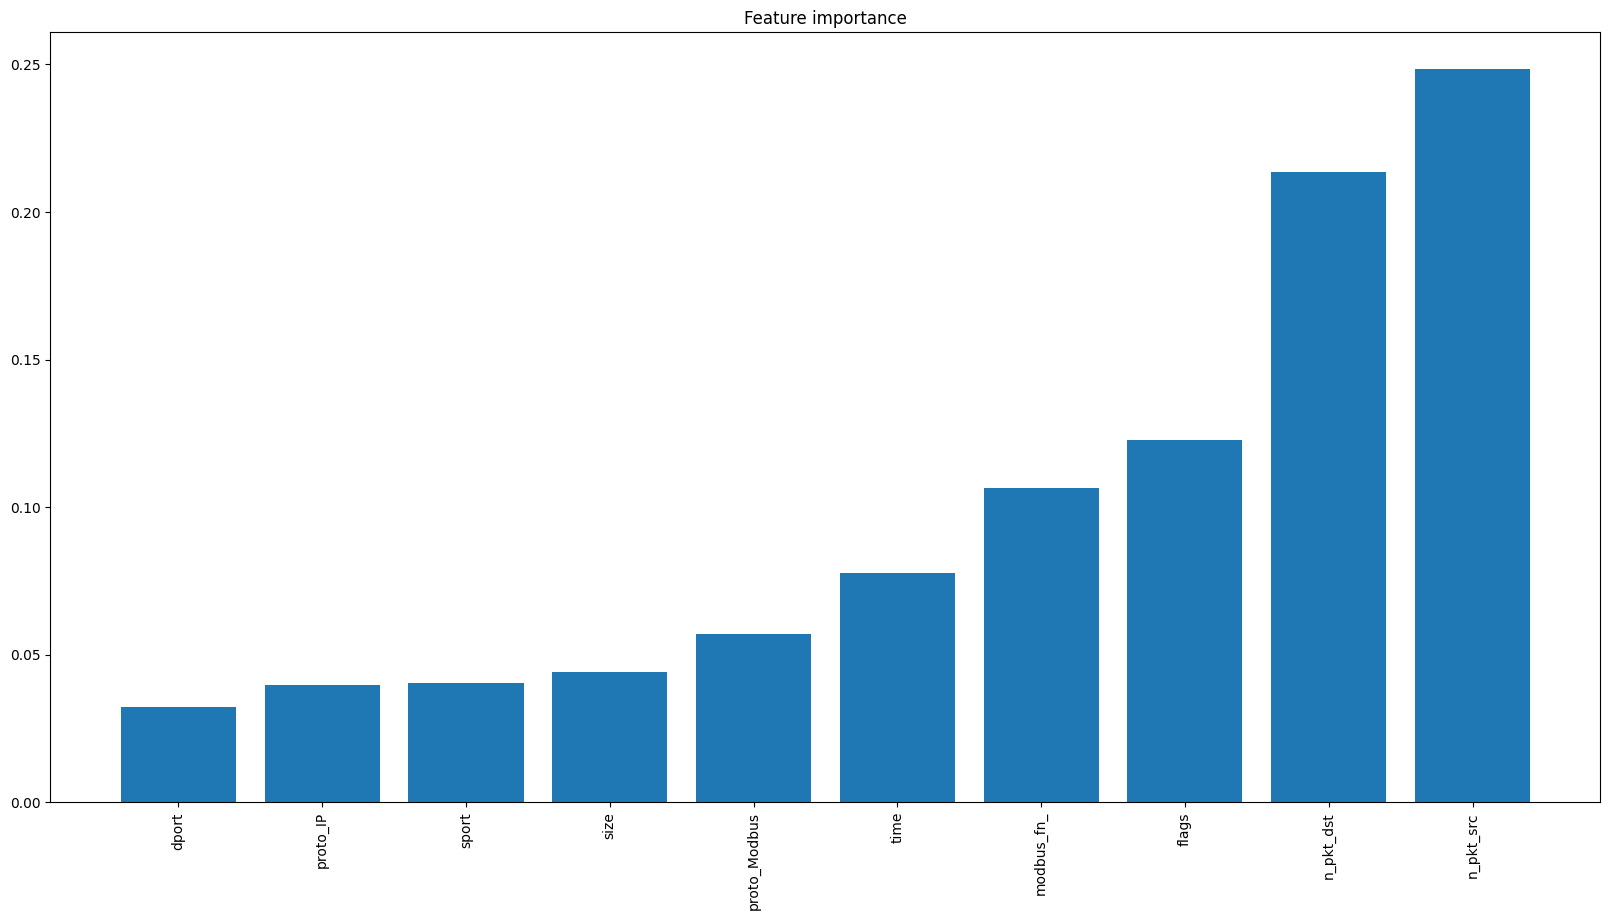

In [80]:
# plot feature importance
importance = rf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()

#### Multi-class classification

In [81]:
rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train["new_labels"])

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [82]:
preds = rf.predict(X_test)

In [84]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))

Accuracy:  0.873902042663485
Precision:  0.3704005183006157
Recall:  0.39102955691040353
F1:  0.3794329828017811


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

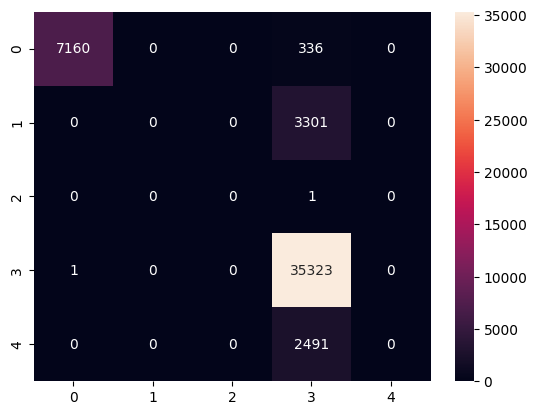

In [85]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")